# Human Activity Recognition(HAR)

- Reference article: https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- Reference code: https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb
- Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

---

* Convert and reformat **accelerometer data** into a **time-sliced representation**
* **Visualize** the accelerometer data
* Reshape the **multi-dimensional tabular data**

## Overview

- **accelererometer data** from a smartphone
    - x, y, z axis acceleration
    - timestamp
    - person ID
- **6 acitivites**
    - Walking
    - Jogging
    - Sitting
    - Standing
    - Upstairs
    - DownStairs
- **Model**: trained to classify between each of the 6 activities.
    1. DNN
    2. 1D CNN

In [11]:
import os
import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Check if CUDA is available (for GPU usage)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Constants
- TIME_PERIODS: the length of the time segment
- STEP_DISTANCE: the amount of overlap between two consecutive time segments

In [12]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Class labels
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80  # The number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS,
# then there is no overlap between the segments
STEP_DISTANCE = 40

#print('torch version ', torch.__version__)


# Data

I used `/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt` data.
> (another dataset (later): `/kaggle/input/human-activity-recognition/time_series_data_human_activities.csv`)

In [13]:
# Define some functions to read the data and show some basic info about the data

def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)
    # Last column has a ";" character which must be removed
    df['z-axis'].replace(regex=True,
                         inplace=True,
                         to_replace=r';',
                         value=r'')
    # Transform 'z-axis' column to float
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0, how='any', inplace=True)  # Drop NaN values

    return df

def convert_to_float(x):
    try:
        return np.float32(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    # Shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))


The data can be downloaded from **[here](https://www.kaggle.com/datasets/sosoyeong/wisdm-raw)**.

Then 'file_path' the directory to where you have put the data.

In [14]:
file_path = 'data/WISDM_ar_v1.1_raw.txt'
df = read_data(file_path)

In [15]:
show_basic_dataframe_info(df)
df.head(10)

Number of rows in the dataframe: 1098208
Number of columns in the dataframe: 6


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


- We have more data for walking and jogging activities more than other activities.
- 36 participants

<br>

**Accelerometer data** for six activities
- sampling rates 20Hz (20 values per second)
    - first 180 records == 9 second interval
        - 1/200 * 180 = 9 seconds

In [16]:
# Data augmentation : add gaussian noise to data
np.random.seed(42)
# Same "ordre de grandeur" for the three features/axis
print(np.min(df["x-axis"]), np.max(df["x-axis"]))
print(np.min(df["y-axis"]), np.max(df["y-axis"]))
print(np.min(df["z-axis"]), np.max(df["z-axis"]))
# Same standard deviations for all axis
std_dev_x = 0.1
std_dev_y = 0.1
std_dev_z = 0.1

# Generate Gaussian noise
noise_x = np.random.normal(loc=0, scale=std_dev_x, size=len(df))
noise_y = np.random.normal(loc=0, scale=std_dev_y, size=len(df))
noise_z = np.random.normal(loc=0, scale=std_dev_z, size=len(df))

# Add noise to the three columns
df["x-axis"] += noise_x
df["y-axis"] += noise_y
df["z-axis"] += noise_z

# See if big changes in the features
print(np.min(df["x-axis"]), np.max(df["x-axis"]))
print(np.min(df["y-axis"]), np.max(df["y-axis"]))
print(np.min(df["z-axis"]), np.max(df["z-axis"]))

-19.61 19.95
-19.61 20.04
-19.8 19.61
-19.952892289680214 20.314995060025645
-19.918266402551644 20.35315611801643
-19.94796041890189 19.702095412471632


In [48]:
# Time shifting to data
# Shift max : max shift to apply
# Sampling rate : diminish the shift max
def manipulate(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    print(shift)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    #if shift > 0:
    #     augmented_data[:shift] = 0
    #else:
    #    augmented_data[shift:] = 0
    return augmented_data

In [52]:
data = np.array(df[['x-axis', 'y-axis', 'z-axis']])
augmented_data = manipulate(data, sampling_rate=0.8, shift_max=20, shift_direction="left")
df[['x-axis', 'y-axis', 'z-axis']] = augmented_data

8


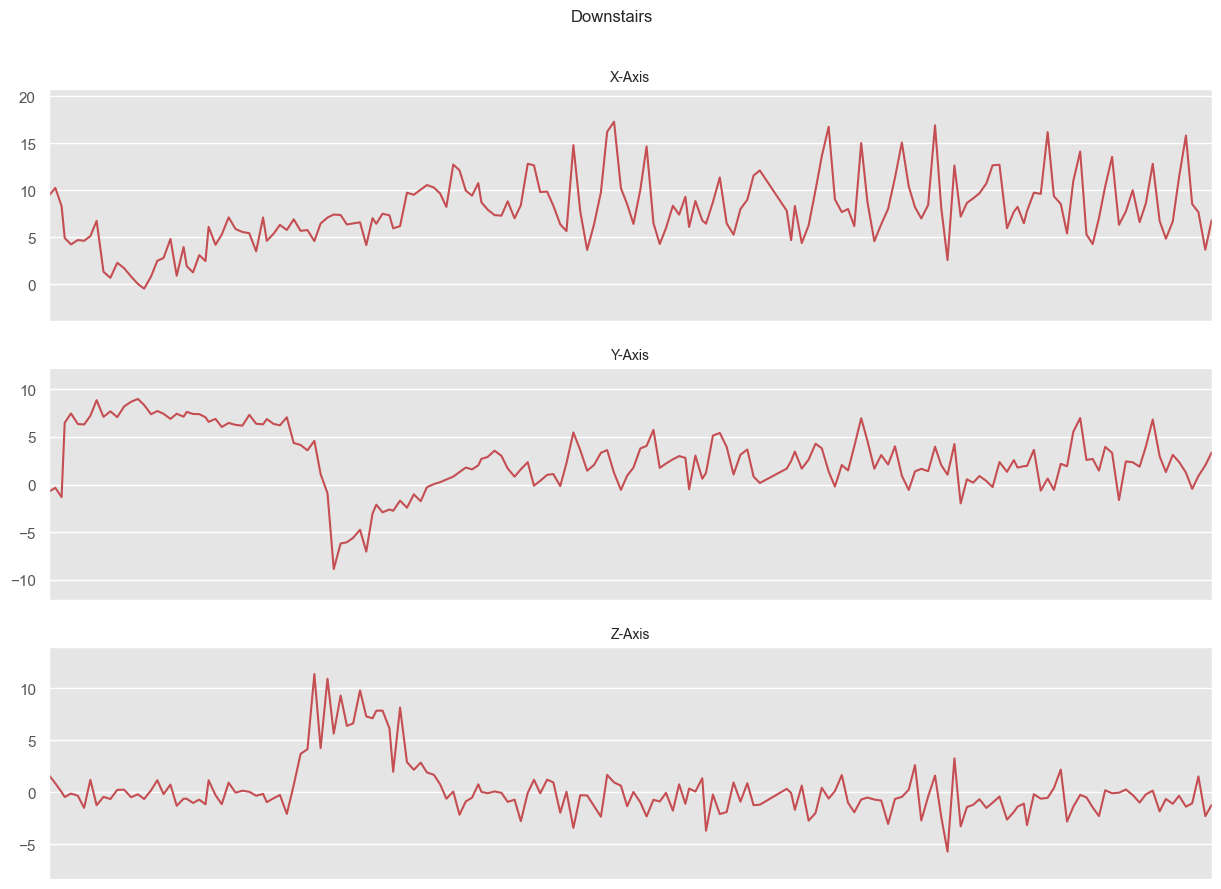

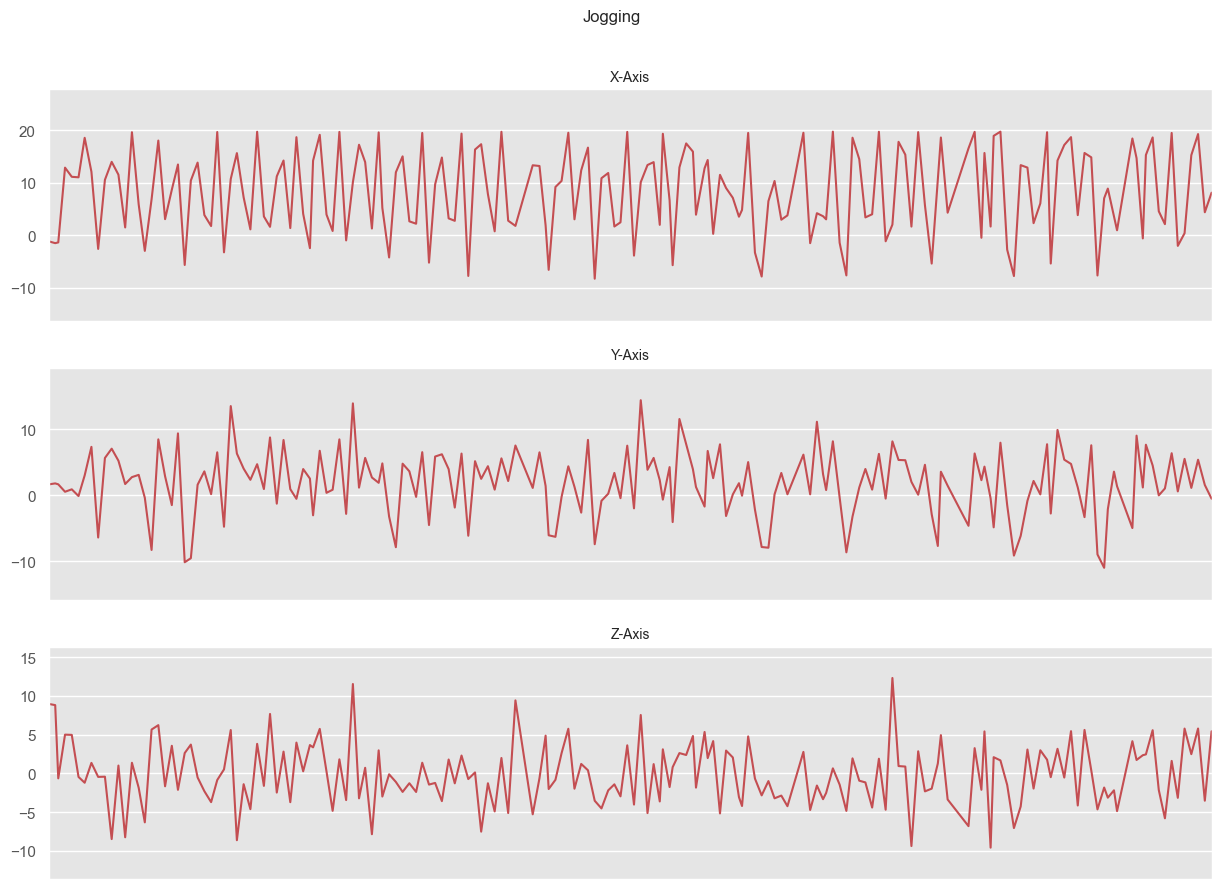

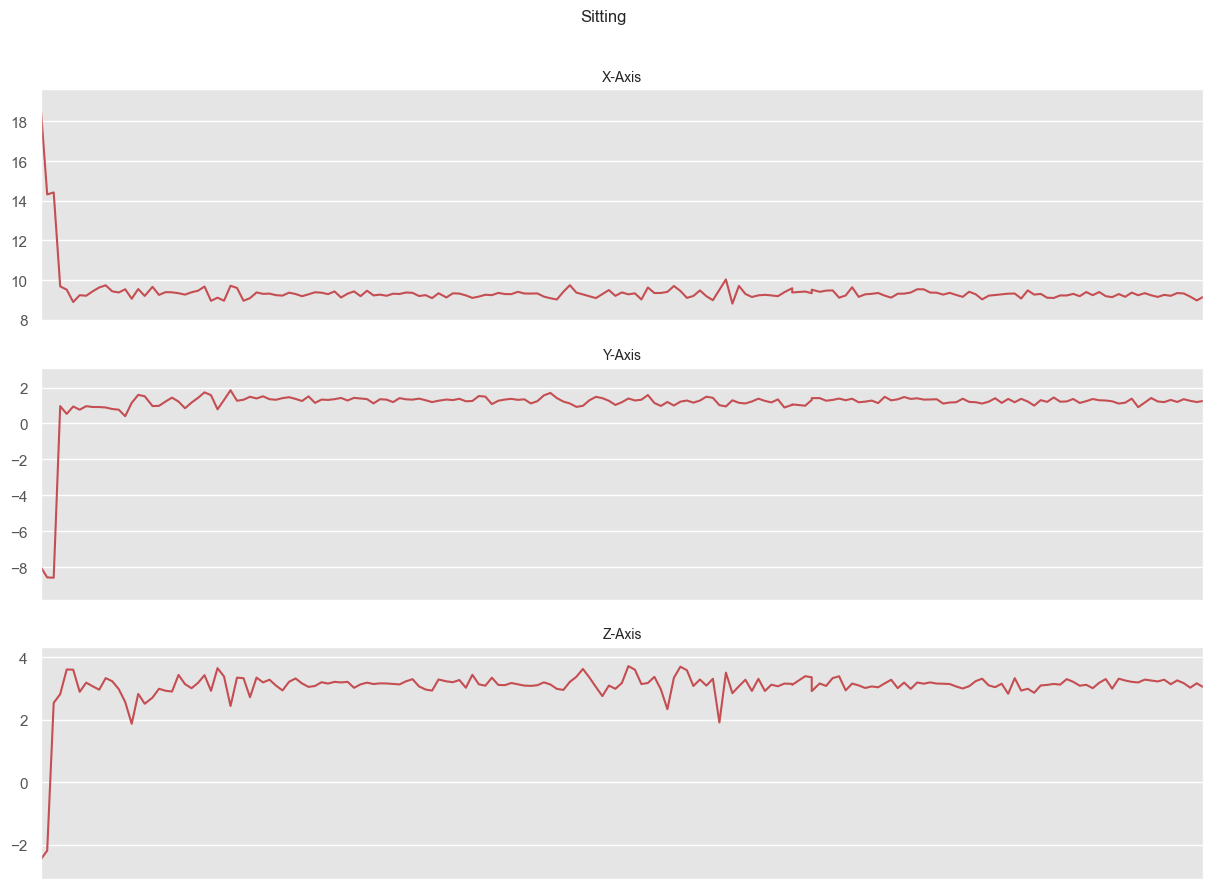

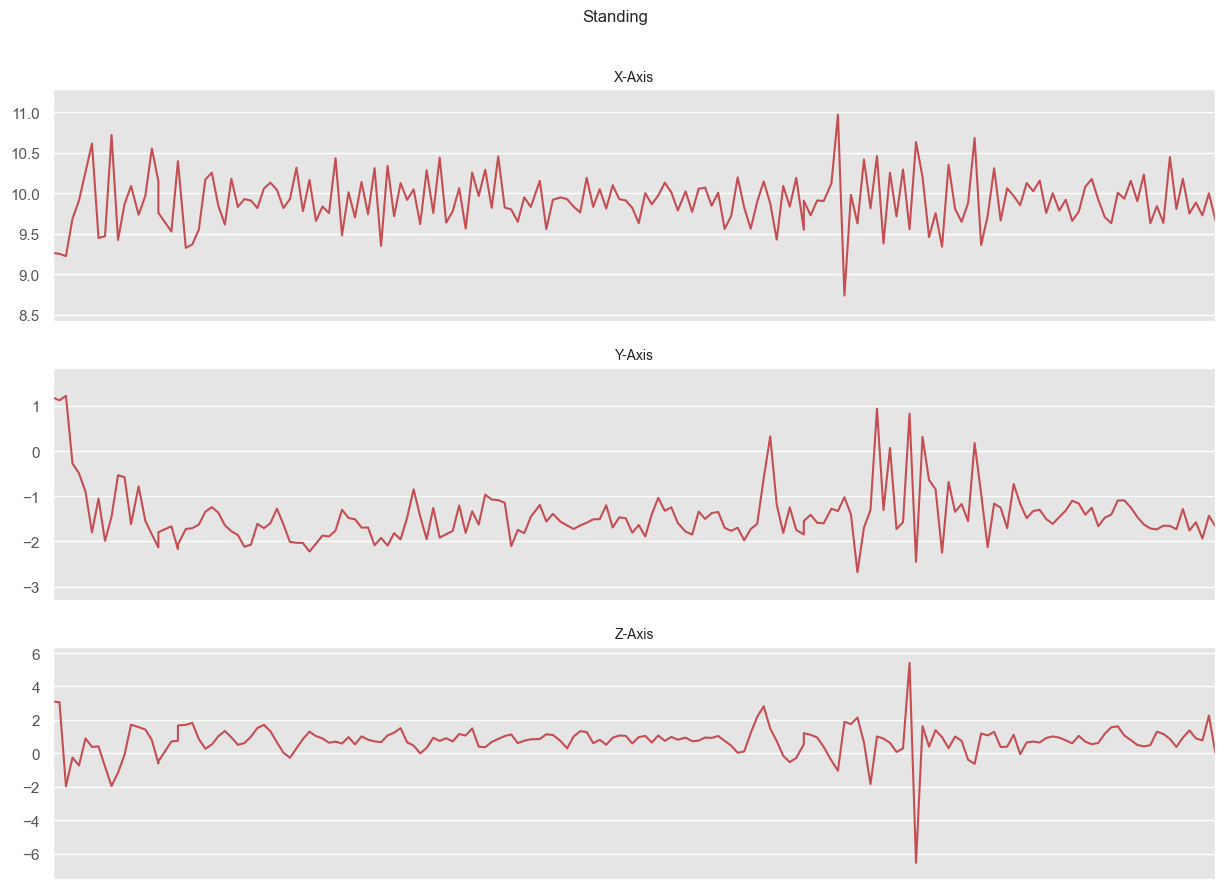

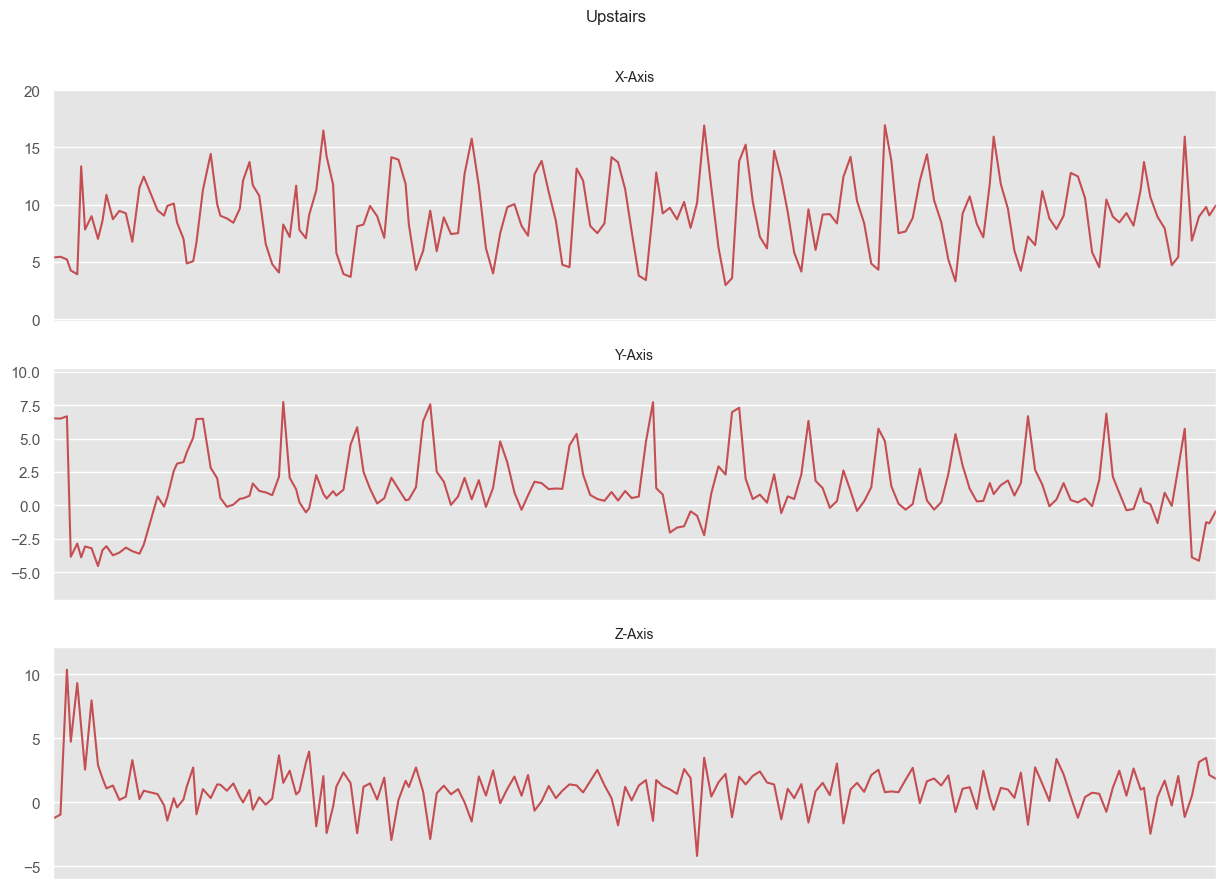

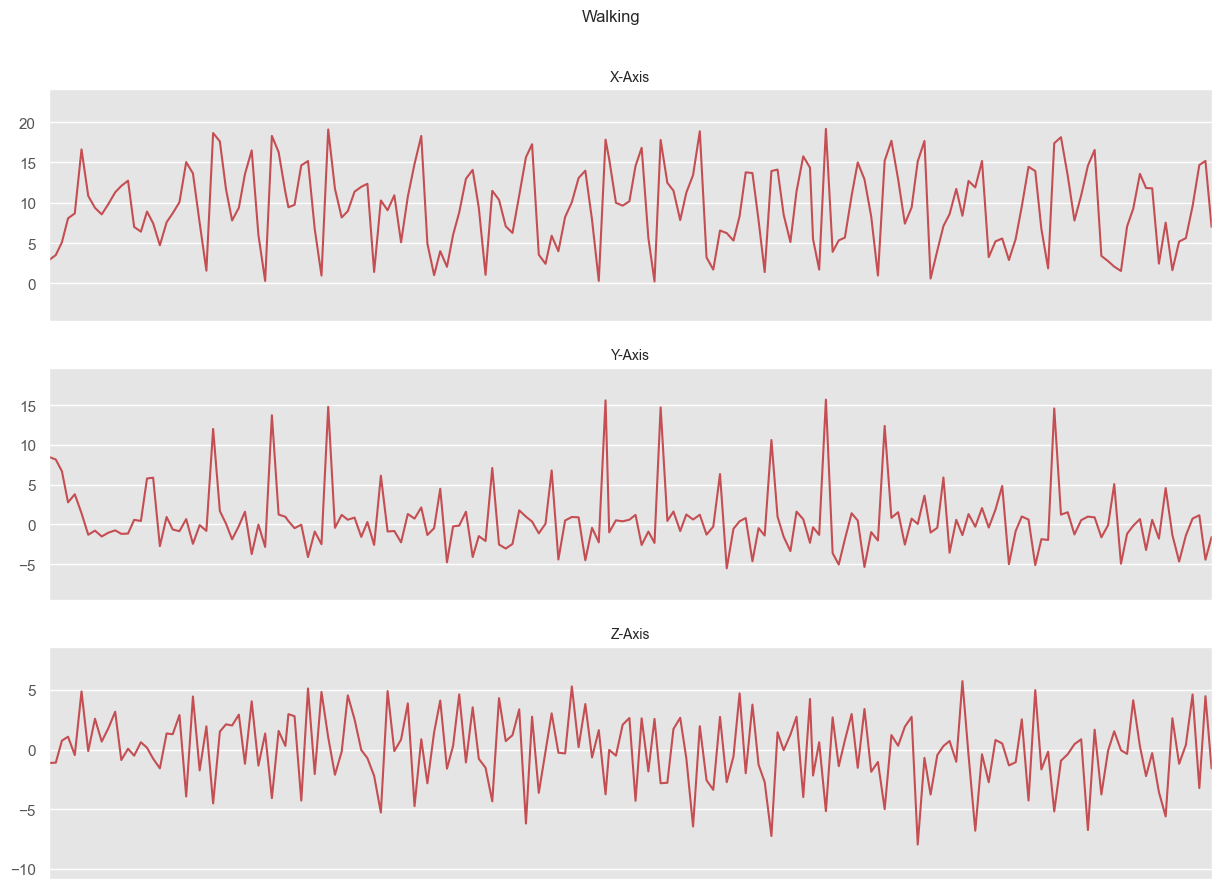

In [54]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')  # x
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')  # y
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')  # z
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]  # check only for first 180 records (9 seconds)
    plot_activity(activity, subset)

Activies like Walking and Jogging has higher acceleration compared to Sitting.

Add **new column** called **'ActivityEncoded'** to the dataframe
- encoded value for each activity
- Why?
    - DNN only work with numerical labels
        - **need to change string label to number!**
            0. Downstairs
            1. Jogging
            2. Sitting
            3. Standing
            4. Upstairs
            5. Walking

In [6]:
LABEL = 'ActivityEncoded' # from 0 to 5

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [11]:
# Split data into train and test set
# train: user 1 ~ 28
# test: user 28 ~

df_train = df[df['user'] <= 28]
df_test = df[df['user'] > 28]

In [12]:
# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()


# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_train.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5
8492,17,Walking,57870222246000,0.0,0.5,-0.0,5
8493,17,Walking,57870332292000,0.0,0.5,-0.0,5


Still the dataframe is not ready yet to be fed into a neural network.

So, we need to reshape it.

In [13]:
# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [14]:
print(TIME_PERIODS, STEP_DISTANCE)

80 40


In [15]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


`x_train` has 20868 records of 2D-matrix of shape 80x3.

**Dimensions we need to remeber**

- #_time periods: the number of time periods within 1 record
    - 4 second interval => 80
- #_sensors: 3 (x, y, z axis acceleration)
- #_classes: the number of the nodes for output layer -> 6

In [16]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3


The input data is 2D (80x3).


In [17]:
input_shape = (n_time_periods * n_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input shape:', input_shape)

x_train shape: (20868, 240)
input shape: 240


In [18]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [19]:
# This function transforms integer y classes into one-hot-encoded vectors
def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  torch.Size([20868, 6])


In PyTorch, we need to wrap these NumPy arrays into a dataset and then create a DataLoader for batch processing.

In [20]:
# Define 3 DataLoader : train, validation and test

from torch.utils.data import random_split

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Define validation dataset
total_train_size = len(train_dataset)
train_size = int(0.8 * total_train_size)
val_size = total_train_size - train_size

# Redefine train and validation TensorDatasets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64  # You can change this value as per your need : number of samples that will be processed in each iteration during training or testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Multi-layer Perceptron

In [21]:
# Put the hyperparameters that gave be the best accuracy on validation set

class MyModel(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MyModel, self).__init__() # calls the constructor of the base class (nn.Module)
        self.time_periods = time_periods
        self.n_classes = n_classes

        # Flatten layer to reshape the input tensor
        self.flatten = nn.Flatten()

        # Fully connected layers with ReLU activation
        self.fc1 = nn.Linear(time_periods*3, 100)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(100, 100)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(100, 100)
        self.relu3 = nn.ReLU()

        # Final fully connected layer without activation for classification
        self.fc4 = nn.Linear(100, n_classes)

        #raise NotImplementedError

    def forward(self, x):
      x = self.flatten(x)
      x = self.relu1(self.fc1(x))
      x = self.relu2(self.fc2(x))
      x = self.relu3(self.fc3(x))
      x = self.fc4(x)
      x = F.softmax(x, dim=1)
      return x
      #raise NotImplementedError  # Using log_softmax for numerical stability

    def predict(self, x):
        self.eval()

        # Convert numpy array to PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)

        # Perform forward pass to get predictions
        with torch.no_grad():
          x_tensor = x_tensor.to(device)
          probabilities = self.forward(x_tensor)

        return probabilities.cpu().numpy()

# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MyModel(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

MyModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)


In [22]:
# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
#my_optimizer = torch.optim.SGD(model_mlp.parameters(), lr=0.01)
#my_optimizer = torch.optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)
my_optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)


In [23]:
#BATCH_SIZE = 400 # no impact because not passed as an argument above
EPOCHS = 500

train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

def train(model, device, num_epochs, optimizer):
    # Initialize lists to store train/validation losses and accuracies
    global train_losses, val_losses, train_accs, val_accs

    model.train()
    for epoch in range(num_epochs): # Iteration over train epochs
        running_train_loss = 0 # Loss associated with epoch
        total_train = 0 # Number of train instances for this epoch
        correct_train = 0 # Number of train instances that are correctly classified by the model

        for inputs, labels in train_loader: # Iteration over train examples (mini-batchs)
            # This ensures that all operations involving the inputs and labels are performed on the same device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() # we put to zero the gradients of the previous batch
            outputs = model(inputs) # we compute the forward pass of the model : outputs are predictions for the given inputs
            loss = criterion(outputs, labels) # calculate the loss between outputs and labels with the specified criterion
            loss.backward() # backpropagation : computing the gradients of the model parameters with respect to the loss
            optimizer.step() # we update the model parameters using the gradients computed in the backward pass

            running_train_loss += loss.item() # accumulation of loss for each batch

            _, predicted = outputs.max(1) # predicted class for each input in the batch
            total_train += labels.size(0) # increments the total_train variable by the number of samples in the current batch
            correct_train += predicted.eq(labels).sum().item() # calculates the number of correct predictions in the current batch

        # dividing the accumulated running loss by the total number of batches in the training dataset
        average_train_loss = running_train_loss/len(train_loader)
        # dividing the total number of correctly predicted samples by the total number of samples in the training dataset
        train_accuracy = correct_train/total_train

        # Append the metrics to the lists
        train_losses.append(average_train_loss)
        train_accs.append(train_accuracy)

        # Validation dataset
        model.eval()
        running_val_loss = 0
        correct_val = 0
        total_val = 0

        # During inference or validation, where we are not updating the model's parameters based on gradients,
        # it is a good practice to disable gradient computation using torch.no_grad() to optimize memory usage and computational efficiency.
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item()

                _, predicted_val = val_outputs.max(1)
                total_val += val_labels.size(0)
                correct_val += predicted_val.eq(val_labels).sum().item()

        average_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        # Append the metrics to the lists
        val_losses.append(average_val_loss)
        val_accs.append(val_accuracy)

        # Print the metrics during training (every 50 epochs)
        if epoch % 50 == 0 or epoch == num_epochs - 1:
          print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {average_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

  #raise NotImplementedError

def validate(model, device):
  # Initialize lists to store losses and accuracies
  global test_losses, test_accs

  model.eval()
  running_test_loss = 0
  correct_test = 0
  total_test = 0

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

      test_outputs = model(test_inputs)
      test_loss = criterion(test_outputs, test_labels)
      running_test_loss += test_loss.item()

      _, predicted_test = test_outputs.max(1)
      total_test += test_labels.size(0)
      correct_test += predicted_test.eq(test_labels).sum().item()

    average_test_loss = running_test_loss/len(test_loader)
    test_accuracy = correct_test/total_test

    # Append the metrics to the lists
    test_losses.append(average_test_loss)
    test_accs.append(test_accuracy)

    print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

   #raise NotImplementedError

In [24]:
train(model_mlp, device, EPOCHS, my_optimizer)
validate(model_mlp, device)

Epoch [1/500], Training Loss: 1.3970, Training Accuracy: 0.6511, Validation Loss: 1.3158, Validation Accuracy: 0.7288
Epoch [51/500], Training Loss: 1.1428, Training Accuracy: 0.9009, Validation Loss: 1.2102, Validation Accuracy: 0.8328
Epoch [101/500], Training Loss: 1.1272, Training Accuracy: 0.9160, Validation Loss: 1.2043, Validation Accuracy: 0.8395
Epoch [151/500], Training Loss: 1.1208, Training Accuracy: 0.9221, Validation Loss: 1.2005, Validation Accuracy: 0.8421
Epoch [201/500], Training Loss: 1.1136, Training Accuracy: 0.9289, Validation Loss: 1.1904, Validation Accuracy: 0.8517
Epoch [251/500], Training Loss: 1.1107, Training Accuracy: 0.9320, Validation Loss: 1.2021, Validation Accuracy: 0.8412
Epoch [301/500], Training Loss: 1.1122, Training Accuracy: 0.9304, Validation Loss: 1.1916, Validation Accuracy: 0.8515
Epoch [351/500], Training Loss: 1.1061, Training Accuracy: 0.9361, Validation Loss: 1.1919, Validation Accuracy: 0.8488
Epoch [401/500], Training Loss: 1.1021, Tra

In [27]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses):
    # Plot losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()

    plt.tight_layout() # prevent overlapping of subplots
    plt.savefig("images/MLP_bestmodel_valtrainslosses.png")
    plt.show()
    #raise NotImplementedError

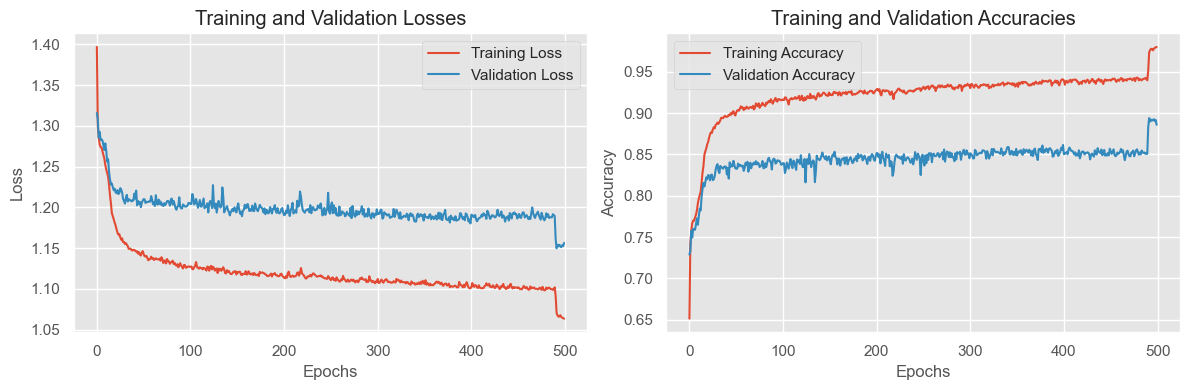

In [28]:
plot_performance(train_losses, val_losses)

Result from the article

![Expectation](attachment:16797bb4-c2ae-4f1b-8a7a-e195e39da9c3.png)

## Test

In [29]:
# normalize test data

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = to_categorical(y_test, n_classes)

print('Accuracy on test data: ', test_accs[-1]) # Final value of the list
print('Loss on test data: ', test_losses[-1])

Accuracy on test data:  0.7566828675577156
Loss on test data:  1.2876343923865012


The test accuray is **about 75%**.

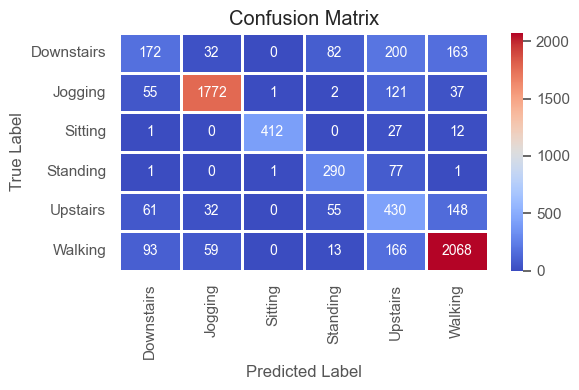

              precision    recall  f1-score   support

           0       0.45      0.27      0.33       649
           1       0.94      0.89      0.91      1988
           2       1.00      0.91      0.95       452
           3       0.66      0.78      0.71       370
           4       0.42      0.59      0.49       726
           5       0.85      0.86      0.86      2399

    accuracy                           0.78      6584
   macro avg       0.72      0.72      0.71      6584
weighted avg       0.79      0.78      0.78      6584



In [31]:
def show_confusion_matrix(validations, predictions, title=None):
    matrix = metrics.confusion_matrix(validations, predictions)

    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig("images/MLP_bestmodel_confusionmatrix_test.png")
    plt.show()

y_pred_test = model_mlp.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [31]:
import itertools
from sklearn.metrics import accuracy_score

# Redefine the model to change the number of hidden layers
class MyModel_tuned(nn.Module):
    def __init__(self, time_periods, n_classes, nb_hidden_layers = 3, activation_function = nn.ReLU()):
        super(MyModel_tuned, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.nb_hidden_layers = nb_hidden_layers
        self.activation_function = activation_function

        # Flatten layer to reshape the input tensor
        self.flatten = nn.Flatten()

        # Input size for the first linear layer
        input_size = time_periods*3

        # Create hidden layers with ReLU activation
        self.hidden_layers = nn.ModuleList() # creates a list of layers
        for layer in range(nb_hidden_layers):
          self.hidden_layers.append(nn.Linear(input_size, 100))
          self.hidden_layers.append(activation_function)
          input_size = 100 # Update input size for the next layer

        # Final fully connected layer without activation for classification
        self.fc_final = nn.Linear(input_size, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.fc_final(x)
        x = F.softmax(x, dim=1)
        return x

# Redefine functions to train and validate the model

# Function to train the model
def train_tuned_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    all_preds = []
    all_labels = []
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if epoch == num_epochs-1:
              _, preds = torch.max(outputs, 1)
              all_preds.extend(preds.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


# Function to evaluate the model
def validate_tuned_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [35]:
# Define hyperparameters to search
batch_sizes = [30, 64, 120]
nb_hidden_layers = [3, 5, 10]
activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
learning_rates = [0.001, 0.005, 0.01]

import random
# Generate all possible combinations
all_combinations = list(itertools.product(batch_sizes, nb_hidden_layers, activation_functions, learning_rates))
# Select randomly 10 configurations
selected_combinations = random.sample(all_combinations, 10)

# Create an empty DataFrame to store the results
results_df = []

for batch_size, nb_hidden_layer, activation_function, learning_rate in selected_combinations:
    # Create the model with the current hyperparameters
    model = MyModel_tuned(TIME_PERIODS, n_classes, nb_hidden_layer, activation_function)
    model.to(device)

    # Choose your Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Define your DataLoader with the current batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Train the model
    accuracy_train = train_tuned_model(model, train_loader, criterion, optimizer, EPOCHS)

    # Validate the model
    accuracy_val = validate_tuned_model(model, val_loader)

    # Check if this set of hyperparameters gives better accuracy
    print(f"batch_size: {batch_size}, nb_hidden: {nb_hidden_layer}, activation_function: {activation_function}, learning rate: {learning_rate}, accuracy_train: {accuracy_train}, accuracy_val: {accuracy_val}")
    results_df.append([batch_size, nb_hidden_layer, activation_function, learning_rate, accuracy_train, accuracy_val])

df = pd.DataFrame(results_df)
# Export the DataFrame to a CSV file
df.to_csv("results_MLP_hyperparam.csv", index=False)


batch_size: 30, nb_hidden: 5, activation_function: Sigmoid(), learning rate: 0.005, accuracy_train: 0.6559841859350665, accuracy_val: 0.661715380929564
batch_size: 120, nb_hidden: 5, activation_function: Tanh(), learning rate: 0.001, accuracy_train: 0.9650173715107224, accuracy_val: 0.8780546238620028
batch_size: 64, nb_hidden: 3, activation_function: ReLU(), learning rate: 0.001, accuracy_train: 0.9735833233497064, accuracy_val: 0.896741734547197
batch_size: 120, nb_hidden: 10, activation_function: ReLU(), learning rate: 0.001, accuracy_train: 0.6958787588355098, accuracy_val: 0.6990896022999521
batch_size: 30, nb_hidden: 5, activation_function: Sigmoid(), learning rate: 0.01, accuracy_train: 0.3160416916257338, accuracy_val: 0.3095352180162913
batch_size: 64, nb_hidden: 10, activation_function: Tanh(), learning rate: 0.001, accuracy_train: 0.4113453935545705, accuracy_val: 0.4262098706276953
batch_size: 120, nb_hidden: 5, activation_function: ReLU(), learning rate: 0.001, accuracy_tr

---

# 1D CNN

* Reference article: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
* Reference code: https://github.com/ni79ls/har-keras-cnn/blob/master/20180903_Keras_HAR_WISDM_CNN_v1.0_for_medium.py

 A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.


This applies well to the analysis of time sequences of sensor data (such as gyroscope or accelerometer data). It also applies to the analysis of any kind of signal data over a fixed-length period (such as audio signals).


In [35]:
class MyConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(self.n_sensors, 100, kernel_size=10)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.relu4 = nn.ReLU()

        # Pooling and dropout
        self.maxpool = nn.MaxPool1d(kernel_size=3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

        #raise NotImplementedError

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x_batch_size = x.size(0)
        x = x.reshape(x_batch_size, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))

        # Global average pooling and dropout
        x = self.avgpool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.reshape(x_batch_size, -1)

        # Output layer with softmax activation
        x = self.fc(x)

        # output the loss, Use log_softmax for numerical stability
        x = F.log_softmax(x, dim=1)
        return x

        #raise NotImplementedError
    
    def predict(self, x):
        self.eval()

        # Convert numpy array to PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)

        # Perform forward pass to get predictions
        with torch.no_grad():
          x_tensor = x_tensor.to(device)
          probabilities = self.forward(x_tensor)

        return probabilities.cpu().numpy()

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = MyConvModel(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

MyConvModel(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (relu2): ReLU()
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (relu3): ReLU()
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (relu4): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)


In [36]:
BATCH_SIZE = 400
EPOCHS = 200

# Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
best_val_loss = float('inf')
patience = 100
trigger_times = 0

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train_cnn(model, device, num_epochs, my_optimizer):
    # Initialize lists to store losses and accuracies
    global train_losses, val_losses, train_accs, val_accs, best_val_loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            my_optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            my_optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = correct_train/total_train
        train_losses.append(running_loss/len(train_loader))
        train_accs.append(train_acc)

        # Validation
        val_acc, val_loss = validate_cnn(model, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print the metrics during training (every 50 epochs)
        if epoch % 25 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_acc:.4f}, '
                  f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
                break

    return train_losses, val_losses, train_accs, val_accs

def validate_cnn(model, device):
    #raise NotImplementedError
    model.eval()
    running_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = correct_val/total_val
    val_loss = running_loss/len(val_loader)
    return(val_acc, val_loss)

In [37]:
print('Training the model...')

train_cnn(model_cnn, device, EPOCHS, my_optimizer)
validate_cnn(model_cnn, device)

Training the model...
Epoch [1/200], Training Loss: 0.5801, Training Accuracy: 0.7820, Validation Loss: 0.2975, Validation Accuracy: 0.8713
Epoch [26/200], Training Loss: 0.0100, Training Accuracy: 0.9977, Validation Loss: 0.0880, Validation Accuracy: 0.9794
Epoch [51/200], Training Loss: 0.0066, Training Accuracy: 0.9984, Validation Loss: 0.1130, Validation Accuracy: 0.9856


In [ ]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses):
    # Plot losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()

    plt.tight_layout() # prevent overlapping of subplots
    #plt.savefig("images/CNN_bestmodel_valtrainslosses.png")
    plt.show()

plot_perfomance(train_losses, val_losses)

In [ ]:
# Confusion matrix on test set
def show_confusion_matrix(validations, predictions, title=None):
    matrix = metrics.confusion_matrix(validations, predictions)

    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    #plt.savefig("images/CNN_bestmodel_confusionmatrix_test.png")
    plt.show()

y_pred_test = model_cnn.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [ ]:
# Redefine the model to change the number of hidden layers
class MyConvModel_tuned(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes, 
                 nb_conv_layers = 4, activation_function = nn.ReLU(), 
                 pooling = "max", kernel_size = 10, stride = 1):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes
        self.nb_conv_layers = nb_conv_layers
        self.activation_function = activation_function
        self.pooling = pooling
        self.kernel_size = kernel_size
        self.stride = stride

        # Input size for the first linear layer
        input_size = self.n_sensors

        # Create hidden layers with ReLU activation
        self.conv_layers = nn.ModuleList() # creates a list of layers
        for layer in range(nb_conv_layers):
            if layer <= 1:
                self.conv_layers.append(nn.Conv1d(input_size, 100,
                                                  kernel_size = self.kernel_size,
                                                  stride = self.stride))
                self.conv_layers.append(activation_function)
                input_size = 100 # Update input size for the next layer
            else :
                self.conv_layers.append(nn.Conv1d(input_size, 160,
                                                  kernel_size = self.kernel_size,
                                                  stride = self.stride))
                self.conv_layers.append(activation_function)
                input_size = 160 # Update input size for the next layer

        # Pooling and dropout
        if pooling == "max":
            self.pool = nn.MaxPool1d(kernel_size=3)
        else :
            self.pool = nn.AvgPool1d(kernel_size=3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

        #raise NotImplementedError

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x_batch_size = x.size(0)
        x = x.reshape(x_batch_size, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            # Pooling every 2 layers
            if i % 2 == 0 & i != 0 & i < len(self.nb_conv_layers)-1:
                x = self.pool(x)

        # Global average pooling and dropout
        x = self.avgpool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.reshape(x_batch_size, -1)

        # Output layer with softmax activation
        x = self.fc(x)

        # output the loss, Use log_softmax for numerical stability
        x = F.log_softmax(x, dim=1)
        return x

# Redefine functions to train and validate the model

# Function to train the model
def train_tuned_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    all_preds = []
    all_labels = []
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if epoch == num_epochs-1:
              _, preds = torch.max(outputs, 1)
              all_preds.extend(preds.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


# Function to evaluate the model
def validate_tuned_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [ ]:
# Define hyperparameters to search
nb_conv_layers = [2, 4, 8]
activation_functions = [nn.ReLU(), nn.LeakyReLU()]
poolings = ["max", "avg"]
kernel_sizes = [10, 30, 50]
strides = [1, 3, 5]

import random
# Generate all possible combinations
all_combinations = list(itertools.product(nb_conv_layers, activation_functions, poolings, kernel_sizes, strides))
# Select randomly 10 configurations
selected_combinations = random.sample(all_combinations, 10)

# Create an empty DataFrame to store the results
results_df = []

for nb_conv_layer, activation_function, pooling, kernel_size, stride in selected_combinations:
    # Create the model with the current hyperparameters
    model = MyConvModel_tuned(TIME_PERIODS, n_sensors, n_classes,
                              nb_conv_layers = nb_conv_layer, activation_function = activation_function,
                              pooling = pooling, kernel_size = kernel_size, stride = stride)
    model.to(device)

    # Choose your Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    accuracy_train = train_tuned_model(model, train_loader, criterion, optimizer, EPOCHS)

    # Validate the model
    accuracy_val = validate_tuned_model(model, val_loader)

    # Check if this set of hyperparameters gives better accuracy
    print(f"nb_conv: {nb_conv_layer}, activation_function: {activation_function}, pooling: {pooling}, kernel_size: {kernel_size}, stride: {stride}, accuracy_train: {accuracy_train}, accuracy_val: {accuracy_val}")
    results_df.append([nb_conv_layer, activation_function, pooling, kernel_size, stride, accuracy_train, accuracy_val])

df = pd.DataFrame(results_df)
# Export the DataFrame to a CSV file
df.to_csv("results_CNN_hyperparam.csv", index=False)